In [356]:
library('pROC')
library('IRdisplay')
library('lme4')
library('Hmisc')
library('MLmetrics')
library('ggExtra')

In [5]:
# run after Error Prediction Model - Data Preparation, where wordLevelChanges.csv is built
# Note that this notebook is in R, whereas data preparation was in Python

In [357]:
wdfs = read.csv('output/wordLevelChanges.csv', stringsAsFactors=F)
wdfs$change = sapply(wdfs$code, function(x){
    if (x == 'M'){
        return(0)
    } else { 
        return(1)
    }
})
wdfs$one =1

In [358]:
names(wdfs)

[1] "X"                                                  
  [2] "bnc_unigram_index"                                  
  [3] "bnc_unigram_prob"                                   
  [4] "bnc_unigram_word"                                   
  [5] "bnc_trigram_index"                                  
  [6] "bnc_trigram_prob"                                   
  [7] "bnc_trigram_word"                                   
  [8] "roark_scores_prefix"                                
  [9] "roark_scores_word"                                  
 [10] "roark_scores_prefix.1"                              
 [11] "roark_scores_srprsl"                                
 [12] "roark_scores_SynSp"                                 
 [13] "roark_scores_LexSp"                                 
 [14] "roark_scores_ambig"                                 
 [15] "roark_scores_open"                                  
 [16] "roark_scores_rernk"                                 
 [17] "roark_scores_toprr"                                 
 [18] "roark_scores_stps"                                  
 [19] "big_lm_scores_Unnamed..0"                           
 [20] "big_lm_scores_prob"                                 
 [21] "big_lm_scores_word"                                 
 [22] "kenlm_scores_prob"                                  
 [23] "kenlm_scores_preceding"                             
 [24] "kenlm_scores_unk"                                   
 [25] "kenlm_scores_words"                                 
 [26] "sCounter"                                           
 [27] "sentence_index"                                     
 [28] "word"                                               
 [29] "code"                                               
 [30] "input_subject"                                      
 [31] "output_subject"                                     
 [32] "conc_bigram"                                        
 [33] "conc_conc_m"                                        
 [34] "conc_conc_sd"                                       
 [35] "conc_unknown"                                       
 [36] "conc_total"                                         
 [37] "conc_percent_known"                                 
 [38] "conc_subtlex"                                       
 [39] "conc_dom_pos"                                       
 [40] "kpm_alternative_spelling"                           
 [41] "kpm_freq_pm"                                        
 [42] "kpm_dom_pos_subtlex"                                
 [43] "kpm_nletters"                                       
 [44] "kpm_nphon"                                          
 [45] "kpm_nsyll"                                          
 [46] "kpm_lemma_highest_pos"                              
 [47] "kpm_aoa_kup"                                        
 [48] "kpm_perc_known"                                     
 [49] "kpm_aoa_kup_lem"                                    
 [50] "kpm_perc_known_lem"                                 
 [51] "kpm_aoa_bird_lem"                                   
 [52] "kpm_aoa_bristol_lem"                                
 [53] "kpm_aoa_cort_lem"                                   
 [54] "kpm_aoa_schock"                                     
 [55] "pic_ipa"                                            
 [56] "pic_ipa_ss_array"                                   
 [57] "pic_ipa_ss"                                         
 [58] "pic_ipa_n"                                          
 [59] "pic_ortho"                                          
 [60] "pic_ortho_ss_array"                                 
 [61] "pic_ortho_ss"                                       
 [62] "pic_ortho_n"                                        
 [63] "pic_character"                                      
 [64] "pic_character_ss_array"                             
 [65] "pic_character_ss"                                   
 [66] "pic_character_n"                                    
 [67] "lic_mean_surprisal_weighted"       

In [359]:
# convert log probabilities to surprisals
wdfs$bnc_unigram_prob = -1 * wdfs$bnc_unigram_prob
wdfs$bnc_trigram_prob = -1 * wdfs$bnc_trigram_prob
wdfs$kenlm_scores_prob = -1 * wdfs$kenlm_scores_prob
wdfs$big_lm_scores_prob = -1 * wdfs$big_lm_scores_prob

In [360]:
wdfs[1,c('bnc_unigram_prob','bnc_trigram_prob','kenlm_scores_prob','big_lm_scores_prob')]

,bnc_unigram_prob,bnc_trigram_prob,kenlm_scores_prob,big_lm_scores_prob
,<dbl>,<dbl>,<dbl>,<dbl>
1,3.310068,2.994068,3.516777,3.202744


In [361]:
dim(wdfs)

[1] 27290   173

[ ] part of speech  
[X] number of syllables: kpm_nsyll  
[X] word length: kpm_nphon  
[X] aoa_rating: kpm_aoa_kup  
[X] concreteness: conc_conc_m  
[X] phonological neighborhood density: pld20  
[X] contextual diversity: Need Subtlexus: SUBTLCD  

random effects structure
https://www4.stat.ncsu.edu/~reich/ABA/code/DICmixed

In [11]:
wdfs

X,bnc_unigram_index,bnc_unigram_prob,bnc_unigram_word,bnc_trigram_index,bnc_trigram_prob,bnc_trigram_word,roark_scores_prefix,roark_scores_word,roark_scores_prefix.1,⋯,initial_WSJ_gt_trigramProb,initial_WSJ_gt_trigramProb_rank,initial_WSJ_gt_trigramProb_quartile,initial_WSJ_gt_5gramProb,initial_WSJ_gt_5gramProb_rank,initial_WSJ_gt_5gramProb_quartile,thread_id,chain_length,change,one
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
0,0,3.310068,each,0,2.994068,each,pfix:1,each,6.566,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,0,1
1,1,7.309903,nonfiction,1,8.412464,nonfiction,pfix:2,nonfiction,18.290,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,1,1
2,2,3.631093,book,2,3.756868,book,pfix:3,book,28.519,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,0,1
3,3,2.600407,has,3,2.253614,has,pfix:4,has,32.402,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,0,1
4,4,1.681165,a,4,1.317157,a,pfix:5,a,35.256,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,0,1
5,5,3.737589,call,5,3.763689,call,pfix:6,call,44.218,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,0,1
6,6,3.321531,number,6,3.708286,number,pfix:7,number,53.366,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,0,1
7,7,2.162270,on,7,2.029635,on,pfix:8,on,58.319,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,1,1
8,8,2.804867,its,8,2.394903,its,pfix:9,its,62.220,⋯,-25.89379,17,1,-25.89379,17,1,0_0,24,0,1


In [366]:
# interpolate missing values in the input
fixed_effects = c('one','word','bnc_unigram_prob', 'bnc_trigram_prob', 'roark_scores_SynSp', 
'roark_scores_LexSp', 'big_lm_scores_prob', 'kenlm_scores_prob','sCounter', 
'kpm_aoa_kup','kpm_nphon', 'kpm_nsyll','conc_conc_m','pld20', 'SUBTLCD', 
'normalized_biglm_probability', 'normalized_WSJ_Roark_Negative.Log.Probability',
'normalized_BNC_KNN_unigramProb', 'normalized_BNC_KNN_trigramProb',
'normalized_kenlm_probability', 'normalized_bllip_probability', 
'normalized_bllip_wsj_probability', 'normalized_mikolov_wsj_probability','pic_ipa_ss','kenlm_scores_prob')

for(fixed_effect in fixed_effects){
    print(paste(fixed_effect, 'missing', length(which(is.na(wdfs[,fixed_effect]))), 'observations'))
  wdfs[is.na(wdfs[,fixed_effect]), fixed_effect] <- mean(wdfs[,fixed_effect], na.rm = TRUE)
}

[1] "one missing 0 observations"
[1] "word missing 0 observations"


Warning message in mean.default(wdfs[, fixed_effect], na.rm = TRUE):
“argument is not numeric or logical: returning NA”


[1] "bnc_unigram_prob missing 0 observations"
[1] "bnc_trigram_prob missing 0 observations"
[1] "roark_scores_SynSp missing 0 observations"
[1] "roark_scores_LexSp missing 0 observations"
[1] "big_lm_scores_prob missing 0 observations"
[1] "kenlm_scores_prob missing 0 observations"
[1] "sCounter missing 0 observations"
[1] "kpm_aoa_kup missing 5562 observations"
[1] "kpm_nphon missing 435 observations"
[1] "kpm_nsyll missing 435 observations"
[1] "conc_conc_m missing 2457 observations"
[1] "pld20 missing 253 observations"
[1] "SUBTLCD missing 45 observations"
[1] "normalized_biglm_probability missing 0 observations"
[1] "normalized_WSJ_Roark_Negative.Log.Probability missing 0 observations"
[1] "normalized_BNC_KNN_unigramProb missing 0 observations"
[1] "normalized_BNC_KNN_trigramProb missing 0 observations"
[1] "normalized_kenlm_probability missing 0 observations"
[1] "normalized_bllip_probability missing 0 observations"
[1] "normalized_bllip_wsj_probability missing 0 observations"
[1]

# Fixed Effects Logistic Regression

In [367]:
fixed_effects

[1] "one"                                          
 [2] "word"                                         
 [3] "bnc_unigram_prob"                             
 [4] "bnc_trigram_prob"                             
 [5] "roark_scores_SynSp"                           
 [6] "roark_scores_LexSp"                           
 [7] "big_lm_scores_prob"                           
 [8] "kenlm_scores_prob"                            
 [9] "sCounter"                                     
[10] "kpm_aoa_kup"                                  
[11] "kpm_nphon"                                    
[12] "kpm_nsyll"                                    
[13] "conc_conc_m"                                  
[14] "pld20"                                        
[15] "SUBTLCD"                                      
[16] "normalized_biglm_probability"                 
[17] "normalized_WSJ_Roark_Negative.Log.Probability"
[18] "normalized_BNC_KNN_unigramProb"               
[19] "normalized_BNC_KNN_trigramProb"               
[20] "normalized_kenlm_probability"                 
[21] "normalized_bllip_probability"                 
[22] "normalized_bllip_wsj_probability"             
[23] "normalized_mikolov_wsj_probability"           
[24] "pic_ipa_ss"                                   
[25] "kenlm_scores_prob"

In [368]:
# basic fixed effects logistic regression
wdf = wdfs[,fixed_effects]
wdf$changed = as.numeric(wdfs$code != 'M')
model <- glm(changed ~ bnc_unigram_prob + bnc_trigram_prob + roark_scores_LexSp +  roark_scores_SynSp
+ big_lm_scores_prob + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m
, family=binomial(link='logit'),data=wdf)

In [369]:
summary(model)


Call:
glm(formula = changed ~ bnc_unigram_prob + bnc_trigram_prob + 
    roark_scores_LexSp + roark_scores_SynSp + big_lm_scores_prob + 
    sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m, 
    family = binomial(link = "logit"), data = wdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5706  -0.6444  -0.5315  -0.4295   2.4168  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -2.492294   0.081356 -30.634  < 2e-16 ***
bnc_unigram_prob   -0.064418   0.032682  -1.971  0.04872 *  
bnc_trigram_prob    0.202444   0.021231   9.535  < 2e-16 ***
roark_scores_LexSp  0.029362   0.017753   1.654  0.09814 .  
roark_scores_SynSp  0.116196   0.025557   4.547 5.45e-06 ***
big_lm_scores_prob  0.216211   0.016845  12.836  < 2e-16 ***
sCounter            0.091441   0.006155  14.856  < 2e-16 ***
kpm_aoa_kup         0.058568   0.013289   4.407 1.05e-05 ***
kpm_nphon          -0.065788   0.020369  -3.230  0.00124 ** 
kpm_n

Setting levels: control = 0, case = 1

Setting direction: controls < cases



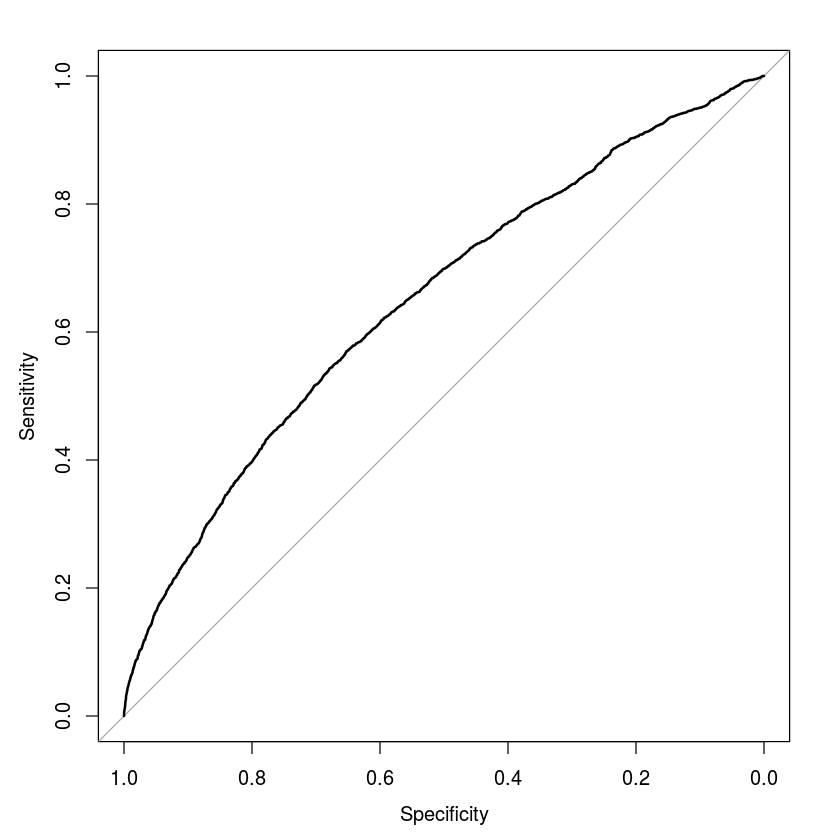

In [370]:
wdfs$predicted = predict(model, wdf, type='response')
df = data.frame(prob=wdfs$predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)
plot(g)    

In [371]:
auc(g)

Area under the curve: 0.6477

In [532]:
colorizeVector = function(vector){
    colorramp = colorRampPalette(c("green", "red"))(n = 101)
    quantiles = quantile(vector, probs=seq(0,1,.01), na.rm=T)
    percentile_limits = sapply(vector, function(x){
        which.max(x <= quantiles)	
    })
    percentile = sapply(percentile_limits, function(x){ifelse(length(x) > 0, x, NA)})
    colors = colorramp[percentile]
    return(colors)
}
wdfs$color = colorizeVector(wdfs$predicted)

colorizeSentence = function(df, sentenceIndex, format = 'HTML'){
    sentence = subset(df, sentence_index == sentenceIndex)
    sentence = sentence[order(sentence$bnc_unigram_index),]
    if (format =='HTML'){
        html_pieces = paste0('<font color="',sentence$color,'">',sentence$word, '</font>')    
        return(paste(html_pieces, collapse =' '))
    } else if (format == 'latex'){
        latex_pieces = paste0('\\textcolor[HTML]{',gsub('#','',sentence$color),'}{',
                              sentence$word,'}')
        #{\color[HTML]{color}text}
        return(paste(latex_pieces, collapse =' '))
    }
}

colorizeSentence(wdfs,1661,'latex')
display_html(colorizeSentence(wdfs,1661))

[1] "\\textcolor[HTML]{38C600}{a} \\textcolor[HTML]{28D600}{single} \\textcolor[HTML]{FF0000}{soothe} \\textcolor[HTML]{DD2100}{has} \\textcolor[HTML]{F40A00}{iron} \\textcolor[HTML]{C13D00}{rods} \\textcolor[HTML]{778700}{and} \\textcolor[HTML]{F70700}{wraps}"

a single soothe has iron rods and wraps

# Mixed Effects Logistic Regression Model

In [373]:
print(names(wdf))
print(nrow(wdf))

 [1] "one"                                          
 [2] "word"                                         
 [3] "bnc_unigram_prob"                             
 [4] "bnc_trigram_prob"                             
 [5] "roark_scores_SynSp"                           
 [6] "roark_scores_LexSp"                           
 [7] "big_lm_scores_prob"                           
 [8] "kenlm_scores_prob"                            
 [9] "sCounter"                                     
[10] "kpm_aoa_kup"                                  
[11] "kpm_nphon"                                    
[12] "kpm_nsyll"                                    
[13] "conc_conc_m"                                  
[14] "pld20"                                        
[15] "SUBTLCD"                                      
[16] "normalized_biglm_probability"                 
[17] "normalized_WSJ_Roark_Negative.Log.Probability"
[18] "normalized_BNC_KNN_unigramProb"               
[19] "normalized_BNC_KNN_trigramProb"         

In [374]:
# add residuals 
wdf$resid_bnc_trigram_prob = lm(bnc_trigram_prob ~ bnc_unigram_prob, data=wdf)$residuals

for (structuredModel in c('roark_scores_SynSp','big_lm_scores_prob','kenlm_scores_prob')){
    wdf[[paste0('resid_',structuredModel)]] = lm(as.formula(paste0(structuredModel, 
        ' ~ bnc_trigram_prob + bnc_unigram_prob')), data=wdf)$residuals
}

In [376]:
wdf$subject_id = as.factor(wdfs$user)
wdf$upstream_subject_id = as.factor(wdfs$upstream_subject_id)

mixed_model <- glmer(changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp 
+ resid_big_lm_scores_prob + resid_kenlm_scores_prob + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))

In [22]:
# how useful is knowing the probability of the sentence -- takes forever to run
#+ normalized_biglm_probability + normalized_WSJ_Roark_Negative.Log.Probability 
#+ normalized_BNC_KNN_unigramProb + normalized_BNC_KNN_trigramProb 
#+ normalized_kenlm_probability + normalized_bllip_probability
#+ normalized_bllip_wsj_probability + normalized_mikolov_wsj_probability        

In [377]:
summary(mixed_model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp +  
    resid_big_lm_scores_prob + resid_kenlm_scores_prob + sCounter +  
    kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 +  
    (1 | subject_id) + (1 | upstream_subject_id)
   Data: wdf
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 23504.8  23619.8 -11738.4  23476.8    27276 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7924 -0.4763 -0.3563 -0.2505  7.2071 

Random effects:
 Groups              Name        Variance Std.Dev.
 subject_id          (Intercept) 0.38308  0.6189  
 upstream_subject_id (Intercept) 0.08795  0.2966  
Number of obs: 27290, groups:  subject_id, 261; upstream_subject_id, 258

Fixed effects:
                          Estimate Std. Error z value Pr

In [477]:
# COM: context-only model
context_only_model <- glmer(changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp 
+ resid_big_lm_scores_prob + resid_kenlm_scores_prob  + (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))
wdfs$com_predicted = predict(context_only_model, wdf, type='response', re.form=NA)
df = data.frame(prob=wdfs$com_predicted, change=wdfs$change)
g_com <- roc(change ~ prob, data = df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [479]:
# SOM: structure only model
structure_only_model <- glmer(changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))
wdfs$som_predicted = predict(structure_only_model, wdf, type='response', re.form=NA)
df = data.frame(prob=wdfs$som_predicted, change=wdfs$change)
g_som <- roc(change ~prob, data = df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [538]:
print('structure_only_model')
print(AIC(structure_only_model))
print('context_only_model')
print(AIC(context_only_model))
print('full model')
print(AIC(mixed_model))

[1] "structure_only_model"
[1] 24445.23
[1] "context_only_model"
[1] 23899.99
[1] "full model"
[1] 23504.77


In [488]:
wdfs$me_predicted = predict(mixed_model, wdf, type='response', re.form=NA)
df = data.frame(prob=wdfs$me_predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



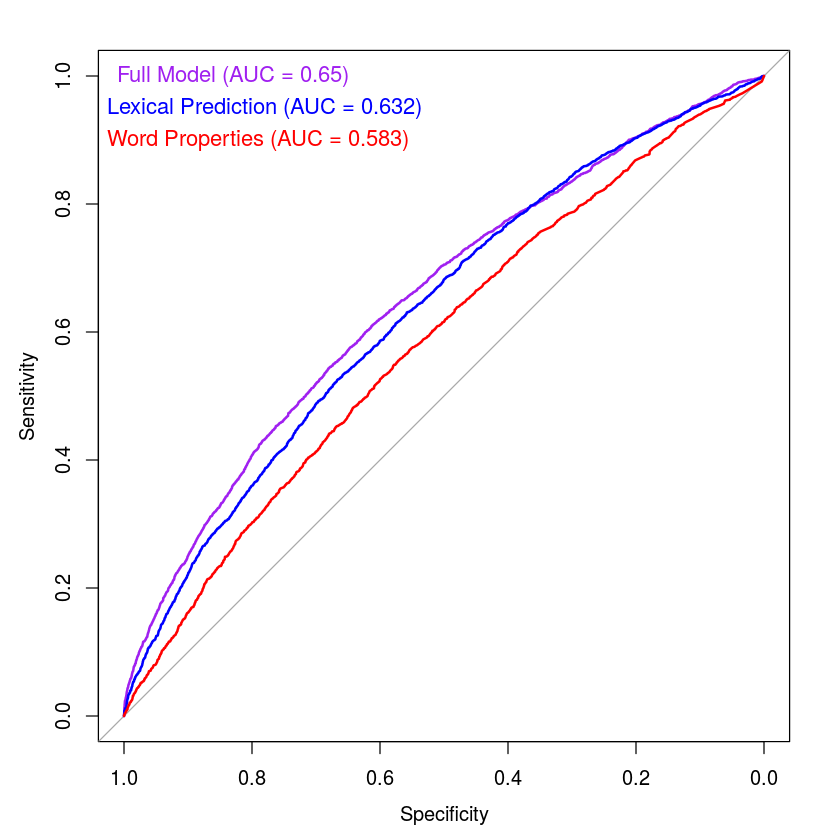

In [490]:
plot(g, col='purple')
text(x = .83, y = 1, labels = paste('Full Model (AUC = ',
      round(auc(g), 3),')', sep=''), cex = 1.1, col = 'purple')
plot(g_com, add=TRUE, col='blue')
text(x = .78, y = .95, labels = paste('Lexical Prediction (AUC = ',
      round(auc(g_com), 3),')', sep=''), cex = 1.1, col = 'blue')
plot(g_som, add=TRUE, col='red')
text(x = .79, y = .9, labels = paste('Word Properties (AUC = ',
    round(auc(g_som), 3),')', sep=''), cex = 1.1, col = 'red')


In [491]:
# get all ROCs on the same curve
pdf('figures/roc_comparison.pdf')
plot(g, col='purple')
text(x = .83, y = 1, labels = paste('Full Model (AUC = ',
      round(auc(g), 3),')', sep=''), cex = 1.1, col = 'purple')
plot(g_com, add=TRUE, col='blue')
text(x = .78, y = .95, labels = paste('Lexical Prediction (AUC = ',
      round(auc(g_com), 3),')', sep=''), cex = 1.1, col = 'blue')
plot(g_som, add=TRUE, col='red')
text(x = .79, y = .9, labels = paste('Word Properties (AUC = ',
    round(auc(g_som), 3),')', sep=''), cex = 1.1, col = 'red')
dev.off()

png 
  2

### Compare the Performance of Each Language Model

In [472]:
lm_predictors = c('bnc_unigram_prob','bnc_trigram_prob','roark_scores_SynSp', 
    'big_lm_scores_prob','kenlm_scores_prob')

lm_nat_lang_names = c('BNC / Unigram','BNC / Trigram','PTB / Roark Parser', 
    'OBWB / Big LM','DS / 5-gram')

model_rocs = list()
lm_models = list()

for (lm_predictor in lm_predictors){
    eq = paste0('changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + ', 
                lm_predictor, ' + (1|subject_id) + (1|upstream_subject_id)')
    print(eq)
    model <- glmer(as.formula(eq), family=binomial(link='logit'),data=wdf, 
    control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=2e5)))
    lm_models[[lm_predictor]] = model
    wdfs[[paste0(lm_predictor,'_predicted')]] = predict(model, wdf, type='response', re.form=NA)
    df = data.frame(prob=wdfs[[paste0(lm_predictor,'_predicted')]], change=wdfs$change)
    g <- roc(change ~ prob, data = df)
    model_rocs[[lm_predictor]] = g
}

[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + bnc_unigram_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + bnc_trigram_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + roark_scores_SynSp + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + big_lm_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + kenlm_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [473]:
colors = c('black', 'red', 'blue','forestgreen','purple','cyan')

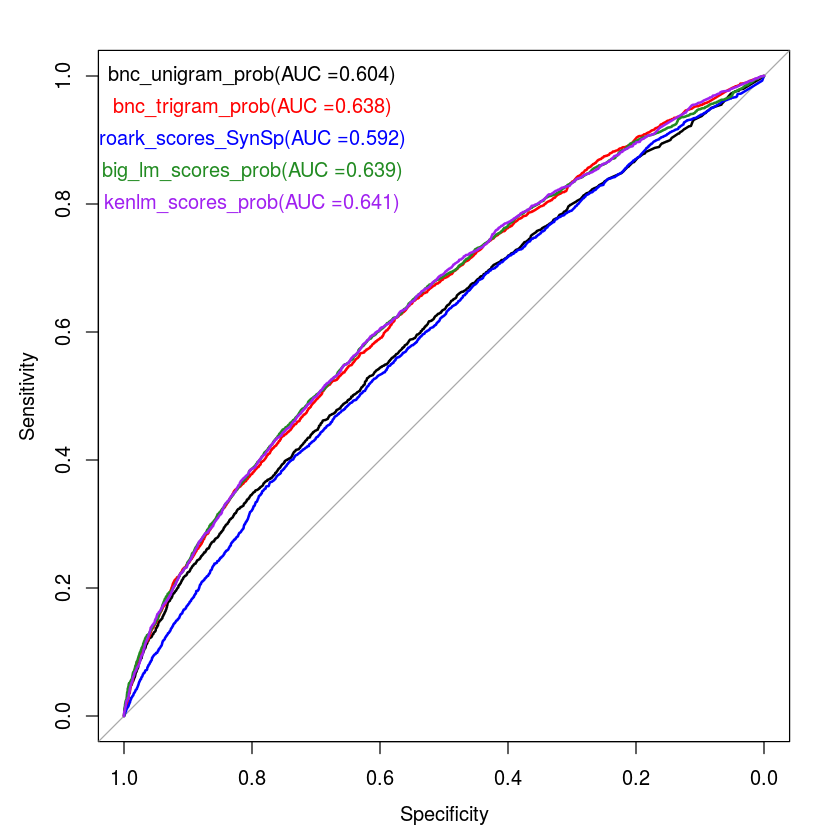

In [474]:
# plot all of the models
for (i in c(1:length(model_rocs))){
    model = model_rocs[[lm_predictors[i]]]
    if (i == 1){
        plot(model, col=colors[i]) 
    } else{
        plot(model, col=colors[i], add=T) 
    }
    text(x=.8, y=1-((i-1) * .05), labels= paste0(lm_predictors[i], 
    '(AUC =', round(auc(model), 3), ')'), col = colors[i]) 
}

In [493]:
prediction_by_model = do.call('rbind', lapply(1:length(model_rocs), function(i){
    model = lm_models[[lm_predictors[i]]]
    aic_score = round(AIC(model))
    roc = model_rocs[[lm_predictors[i]]]
    auc_score = round(auc(roc), 3)
    name = lm_nat_lang_names[i]
    return(data.frame(name, auc_score, aic_score))  
}))

prediction_by_model = prediction_by_model[order(prediction_by_model$aic),]
prediction_by_model

,name,auc_score,aic_score
,<fct>,<dbl>,<dbl>
4,OBWB / Big LM,0.639,23677
5,DS / 5-gram,0.641,23687
2,BNC / Trigram,0.638,23732
1,BNC / Unigram,0.604,24095
3,PTB / Roark Parser,0.592,24370


In [ ]:
# Make this into a table

### Colorize responses

In [508]:
chosen_thread = subset(wdfs, thread_id == "0_5")
sentence_indices = unique(chosen_thread$sentence_index)
sentence_indices

[1] 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
[20] 402 403 404 405 406 407 408

In [526]:
colorizeSentence(wdfs, 383, format='latex')   

[1] "\textcolor[HTML]{966800}{your} \textcolor[HTML]{C63800}{teeth} \textcolor[HTML]{847A00}{begin} \textcolor[HTML]{6B9300}{breaking} \textcolor[HTML]{47B700}{up} \textcolor[HTML]{728C00}{the} \textcolor[HTML]{8E7000}{food} \textcolor[HTML]{EA1400}{by} \textcolor[HTML]{EF0F00}{chewing} \textcolor[HTML]{F70700}{it}"

In [533]:
wdfs$me_predicted = predict(mixed_model, wdf, type='response')
#initial_sentences = subset(wdfs, upstream_pointer ==-1 & global_chain ==0)
chosen_thread = subset(wdfs, thread_id == "0_5")
sentence_indices = unique(chosen_thread$sentence_index)

colHTMLStore = list()
for (sid in sentence_indices){
    # target_index = unique(subset(initial_sentences, stimulus_id == sid)$sentence_index)
    colHTMLStore[[as.character(sid)]] = colorizeSentence(wdfs, sid, format='latex')   
    
    colorHTML = colorizeSentence(wdfs, sid, format='HTML')
    display_html(colorHTML)
}

write(paste0(colHTMLStore, collapse='\n \\\\ \n'), file = "figures/logisticRegression.txt")

your teeth begin breaking up the food by chewing it

your teeth begin breaking up the food by chewing it

your teeth end up breaking up the food by chewing

your teeth end up breaking up the food by chewing

your teeth end up breaking up the food by chewing

your teeth end up breaking up the food by chewing it

her teeth ended up breaking to the food back to you

her teeth ended up breaking as the food got hard

her key ended up breaking off into her car

her key ended up breaking in to her car

our key ended up breaking into the car

our key ended up breaking into the door

berkie ended up breaking in to the door

our key ended up breaking into the door

our key ended up breaking in to the door

her key ended up breaking into the door

her key ended up breaking into the door

her key ended up breaking in the door

her key ended up breaking in the lock

the key ended up breaking in the lock

the key ended up breaking in the lock

the key ended up opening the lock

the key ended up opening the lock

the key ended up opening the lock

the key ended up opening the lock

the key to it is upholding the law

In [26]:
mixed_model_nolms <- glmer(changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = change ~ prob, data = df)

Data: prob in 22482 controls (change 0) < 4808 cases (change 1).
Area under the curve: 0.6876


Area under the curve: 0.6876

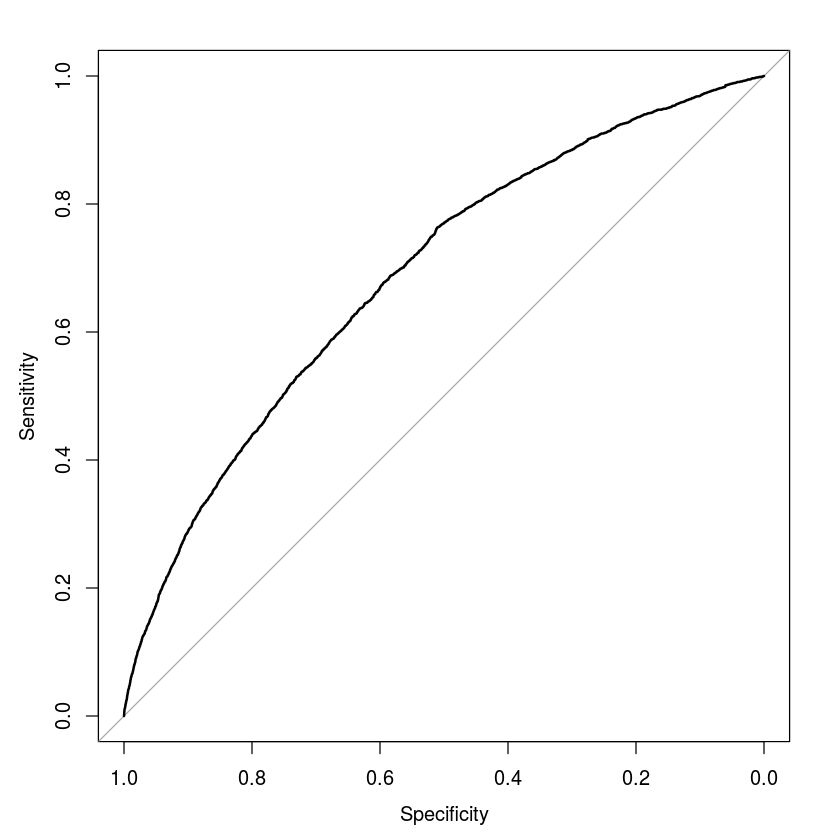

In [27]:
wdfs$nolms_predicted = predict(mixed_model_nolms, wdf, type='response')
df = data.frame(prob=wdfs$nolms_predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)
print(plot(g))
auc(g)

In [28]:
# output the graph
source('telephone_analysis.R')

replacements = list()
replacements[['bnc_unigram_prob']] = 'BNC unigram surprisal'
replacements[['resid_bnc_trigram_prob']] = 'Residualized BNC trigram surprisal'
replacements[['resid_roark_scores_SynSp']] = 'Residualized Roark PCFG syntactic surprisal'
replacements[['resid_big_lm_scores_prob']] = 'Residualized Big LM surprisal'
replacements[['resid_kenlm_scores_prob']] = 'Residualized DS 5-gram surprisal'
replacements[['sCounter']] = 'Position in sentence'
replacements[['kpm_aoa_kup']] = 'Age of acquisition'
replacements[['kpm_nphon']] = 'Number of phonemes'
replacements[['kpm_nsyll']] = 'Number of syllables'
replacements[['conc_conc_m']] = 'Concreteness'
replacements[['pld20']] = 'Phonological Neighborhood Density (PLD20)'
replacements[['upstream_subject_id']] = 'Speaker ID'
replacements[['subject_id']] = 'Listener ID'

modelName = "wordLevel"
wordLevelCaption = 'Mixed-effects logistic regression predicting whether a word will be transmitted successfully on the basis of its surprisal under various language models as well as other word properties. Significance of fixed-effects is computed following \\citet{satterthwaite1946}.'
wordLevelLabel = 'tab:wordlevel_lm'

modelToTable('mixed_logistic', modelName, mixed_model, replacements=replacements,file=paste0('LMs/',modelName,'_lm.tex'), 
        printVars = T, caption = wordLevelCaption, label = wordLevelLabel, where= 't')



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




 [1] "(Intercept)"                                
 [2] "BNC unigram surprisal"                      
 [3] "Residualized BNC trigram surprisal"         
 [4] "Residualized Roark PCFG syntactic surprisal"
 [5] "Residualized Big LM surprisal"              
 [6] "Residualized DS 5-gram surprisal"           
 [7] "Position in sentence"                       
 [8] "Age of acquisition"                         
 [9] "Number of phonemes"                         
[10] "Number of syllables"                        
[11] "Concreteness"                               
[12] "Phonological Neighborhood Density (PLD20)"  
$names
[1] "subject_id"          "upstream_subject_id"

$sc
[1] 1

$useSc
[1] FALSE

$class
[1] "VarCorr.merMod"

[1] "Alisases for random variables"
[1] "Listener ID" "Speaker ID" 


Cross-validation 

In [ ]:
# propotion matches per user

In [23]:
(wdfs$code)

[1] "M" "D" "S"

In [32]:
names(wdfs)

[1] "X"                                                  
  [2] "bnc_unigram_index"                                  
  [3] "bnc_unigram_prob"                                   
  [4] "bnc_unigram_word"                                   
  [5] "bnc_trigram_index"                                  
  [6] "bnc_trigram_prob"                                   
  [7] "bnc_trigram_word"                                   
  [8] "roark_scores_prefix"                                
  [9] "roark_scores_word"                                  
 [10] "roark_scores_prefix.1"                              
 [11] "roark_scores_srprsl"                                
 [12] "roark_scores_SynSp"                                 
 [13] "roark_scores_LexSp"                                 
 [14] "roark_scores_ambig"                                 
 [15] "roark_scores_open"                                  
 [16] "roark_scores_rernk"                                 
 [17] "roark_scores_toprr"                                 
 [18] "roark_scores_stps"                                  
 [19] "big_lm_scores_Unnamed..0"                           
 [20] "big_lm_scores_prob"                                 
 [21] "big_lm_scores_word"                                 
 [22] "kenlm_scores_prob"                                  
 [23] "kenlm_scores_preceding"                             
 [24] "kenlm_scores_unk"                                   
 [25] "kenlm_scores_words"                                 
 [26] "sCounter"                                           
 [27] "sentence_index"                                     
 [28] "word"                                               
 [29] "code"                                               
 [30] "conc_bigram"                                        
 [31] "conc_conc_m"                                        
 [32] "conc_conc_sd"                                       
 [33] "conc_unknown"                                       
 [34] "conc_total"                                         
 [35] "conc_percent_known"                                 
 [36] "conc_subtlex"                                       
 [37] "conc_dom_pos"                                       
 [38] "kpm_alternative_spelling"                           
 [39] "kpm_freq_pm"                                        
 [40] "kpm_dom_pos_subtlex"                                
 [41] "kpm_nletters"                                       
 [42] "kpm_nphon"                                          
 [43] "kpm_nsyll"                                          
 [44] "kpm_lemma_highest_pos"                              
 [45] "kpm_aoa_kup"                                        
 [46] "kpm_perc_known"                                     
 [47] "kpm_aoa_kup_lem"                                    
 [48] "kpm_perc_known_lem"                                 
 [49] "kpm_aoa_bird_lem"                                   
 [50] "kpm_aoa_bristol_lem"                                
 [51] "kpm_aoa_cort_lem"                                   
 [52] "kpm_aoa_schock"                                     
 [53] "pic_ipa"                                            
 [54] "pic_ipa_ss_array"                                   
 [55] "pic_ipa_ss"                                         
 [56] "pic_ipa_n"                                          
 [57] "pic_ortho"                                          
 [58] "pic_ortho_ss_array"                                 
 [59] "pic_ortho_ss"                                       
 [60] "pic_ortho_n"                                        
 [61] "pic_character"                                      
 [62] "pic_character_ss_array"                             
 [63] "pic_character_ss"                                   
 [64] "pic_character_n"                                    
 [65] "lic_mean_surprisal_weighted"                        
 [66] "lic_mean_surprisal_unweighted"                      
 [67] "lic_frequency"                     

# Flag Behavior vs. Edit Behavior

In [337]:
propMatch = aggregate(code ~ output_subject, wdfs, function(x){sum(x == 'M') / length(x)})
names(propMatch) = c('user','propMatch')
numWords =  aggregate(code ~ output_subject, wdfs, function(x){numWords = length(x)})
names(numWords)  = c('user', 'numWords')
numSentences = aggregate(stimulus_id ~ input_subject, wdfs, function(x){length(unique(x))})
names(numSentences) = c('user','numSentencesNotFlagged')
wdfs_users = merge(merge(propMatch, numWords), numSentences)

In [335]:
flag_behavior = rbind(
    read.csv('output/180419_AMT_lengthLimitedGPU_flags.csv',
    stringsAsFactors=F),
    read.csv('output/180624_AMT_lengthLimitedGPU_flags.csv',
    stringsAsFactors=F)
)    

In [336]:
stim_flags = subset(flag_behavior, flag_type == 'stimulus')

In [341]:
flag_reasons = data.frame(table(stim_flags$reason))
flag_reasons = flag_reasons[order(flag_reasons$Freq, decreasing=T),]

In [342]:
flags_per_user  = aggregate(reason ~ user, stim_flags, length)
names(flags_per_user) = c('user','numFlags')

In [343]:
wdfs_users_with_flags = merge(wdfs_users, flags_per_user, all.x=T)
#add back users with 0-counts
wdfs_users_with_flags$numFlags[is.na(wdfs_users_with_flags$numFlags)] = 0
wdfs_users_with_flags$propFlags = wdfs_users_with_flags$numFlags / 
(wdfs_users_with_flags$numFlags + wdfs_users_with_flags$numSentencesNotFlagged)

In [330]:
numFlagsAndUnflagged = sum(wdfs_users_with_flags$numSentencesNotFlagged
                          ) + sum(wdfs_users_with_flags$numFlags)

In [345]:
# Proportion of inputs from other participants which were flagged
sum(wdfs_users_with_flags$numFlags)  / numFlagsAndUnflagged

[1] 0.1533353

In [346]:
flag_reasons$propOfInputs = flag_reasons$Freq / numFlagsAndUnflagged
flag_reasons$propOfFlags = flag_reasons$Freq / sum(flag_reasons$Freq)
head(flag_reasons, n=10)

,Var1,Freq,propOfInputs,propOfFlags
,<fct>,<int>,<dbl>,<dbl>
2,Contains speech errors,149,0.0449743435,0.261403509
249,Speech stops or starts abruptly / speech sounds cut off,119,0.0359191065,0.208771930
80,Other: Couldn't hear anything over the background noise,9,0.0027165711,0.015789474
1,Contains obscenities or objectionable content,5,0.0015092062,0.008771930
93,Other: Drowned out.,5,0.0015092062,0.008771930
220,Other: Too hard to hear,5,0.0015092062,0.008771930
35,Other: Can't hear it,4,0.0012073649,0.007017544
91,Other: difficult to understand,4,0.0012073649,0.007017544
116,Other: I could not understand anything that was said,4,0.0012073649,0.007017544


In [347]:
lm1 = lm((1 - propMatch) ~ numFlags, subset(wdfs_users_with_flags, numWords > 25))
m = summary(lm1)
print(m)


Call:
lm(formula = (1 - propMatch) ~ numFlags, data = subset(wdfs_users_with_flags, 
    numWords > 25))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17964 -0.04493 -0.00374  0.04107  0.34612 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.181655   0.006332  28.686   <2e-16 ***
numFlags    -0.002011   0.001414  -1.423    0.157    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07282 on 167 degrees of freedom
Multiple R-squared:  0.01197,	Adjusted R-squared:  0.006056 
F-statistic: 2.024 on 1 and 167 DF,  p-value: 0.1567



In [348]:
eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(R)^2~"="~r2~","~~italic(p)~"="~pval, 
         list(a = format(coef(m)[1], digits = 2), 
              b = format(coef(m)[2], digits = 2), 
             r2 = round(m$adj.r.squared, 3),
            pval = unname(round(pf(m$fstatistic[1], m$fstatistic[2], m$fstatistic[3],
      lower.tail = FALSE), 3))
             ))

eq = as.character(as.expression(eq))               
eq

[1] "italic(y) == \"0.18\" + \"-0.002\" %.% italic(x) * \",\" ~ ~italic(R)^2 ~ \"=\" ~ 0.006 ~ \",\" ~ ~italic(p) ~ \"=\" ~ 0.157"

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



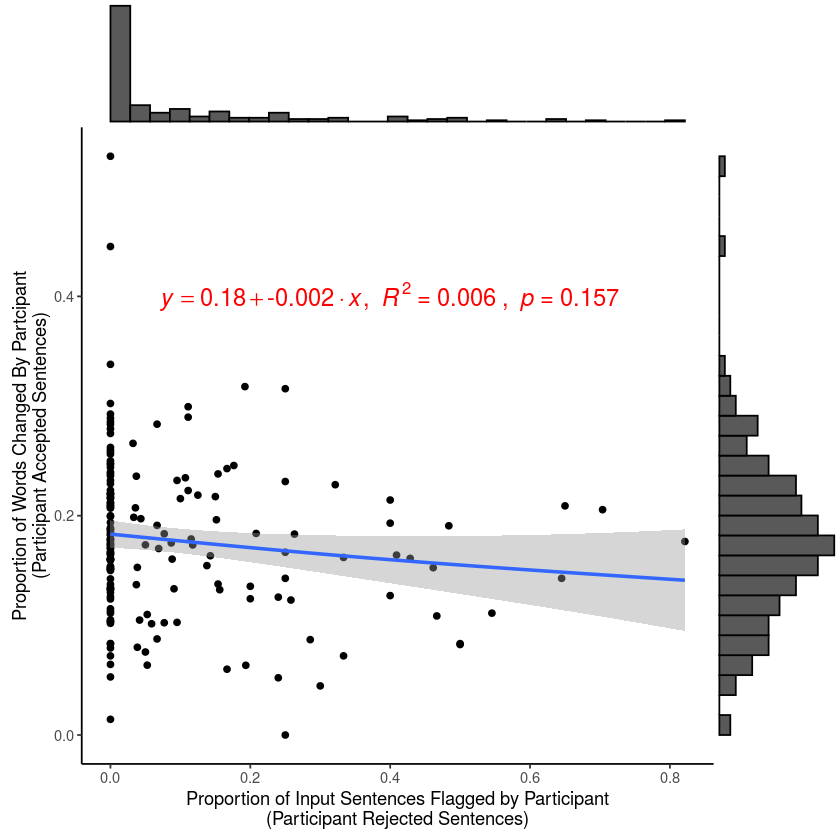

In [349]:
p1= ggplot(subset(wdfs_users_with_flags, numWords > 25)) + geom_point(aes(x=propFlags, y= 1 - propMatch)
) + geom_smooth(aes(x=propFlags, y=1 - propMatch), method='gam') + ylab(
'Proportion of Words Changed By Partcipant\n(Participant Accepted Sentences)') + xlab(
'Proportion of Input Sentences Flagged by Participant\n(Participant Rejected Sentences)'
) + theme_classic() + annotate("text", x = .4, y = .4, label = eq, parse = TRUE, 
    color='red', size=5)
p1 = ggMarginal(p1, type="histogram")
print(p1)

In [297]:
ggsave( 'figures/wordChangesVsFlags.pdf', plot= p1, width=6, height=6)
ggsave( 'figures/wordChangesVsFlags.png', plot= p1, width=6, height=6)